In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.notebook import tqdm
import joblib
from sklearn.neighbors import NearestNeighbors
import tmap as tm
from scipy.stats import rankdata
from matplotlib.colors import ListedColormap
from faerun import Faerun
import os
from map4 import MAP4Calculator
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from rdkit import Chem
from pdga.sequence import smiles_from_seq

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
elements = ["K","L",""]
branching_elements = ["B"]
enumeration = {}
enumeration[1] = [e for e in elements]

for i in range (2,16):
    if i % 4 == 0:
        elements_to_append = branching_elements
    else:
        elements_to_append = elements
    enumeration[i] = set()
    for e in elements_to_append:
        for previous_enumeration in enumeration[i-1]:
            enumeration[i].add( previous_enumeration + e )


In [3]:
len(enumeration[15])

50625

In [4]:
KL_enum = enumeration[15]

In [5]:
lib = pd.read_csv("/data/Peptides/dendrimers/T25_analogs/database/52k.mxfp", sep=" ", header=None)

In [6]:
lib.columns=["SMILES","seq", "MXFP", "prop"]

In [7]:
lib["seq2"] = lib.seq.map(lambda x: x.replace("(", "").replace(")","").replace("8K","B").replace("4K","B").replace("2K","B"))

In [8]:
lib["seq3"] = lib.seq2.map(lambda x: x.replace("B", "4"))

In [9]:
lib["SMILES_old"] = lib["SMILES"]

In [12]:
lib["SMILES"] = lib.seq3.map(smiles_from_seq)

In [13]:
def is_in_KL_enum(seq):
    if seq[0] == "K" and "B"+seq[1:] in KL_enum:
        return True
    elif seq in KL_enum:
        return True
    else:
        return False

In [14]:
lib["in_50k"] = lib.seq2.map(is_in_KL_enum)

In [15]:
lib.query("in_50k == True")

,SMILES,seq,MXFP,prop,seq2,seq3,SMILES_old,in_50k
0,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KLL)8(KLLL)4(KLLL)2KLLL,4;4;6;7;8;9;10;12;15;18;23;30;39;47;55;67;86;1...,432;260;0;53;67;16;1,KLLBLLLBLLLBLLL,KLL4LLL4LLL4LLL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True
1,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KKL)8(KLLL)4(KLLL)2KLLL,4;4;6;7;8;9;10;12;15;18;23;29;38;47;55;67;85;1...,440;260;0;53;75;24;1,KKLBLLLBLLLBLLL,KKL4LLL4LLL4LLL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True
2,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KLL)8(KLLL)4(KLLL)2KLL,4;4;6;7;8;9;10;12;15;18;23;30;39;47;55;66;84;1...,424;255;0;52;66;16;1,KLLBLLLBLLLBLL,KLL4LLL4LLL4LL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CCCCNC(=O)C(CC(...,True
3,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KLL)8(KLLL)4(KLL)2KLLL,4;4;6;7;8;10;10;12;15;18;23;30;39;48;57;70;90;...,416;250;0;51;65;16;1,KLLBLLLBLLBLLL,KLL4LLL4LL4LLL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True
4,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KLL)8(KLL)4(KLLL)2KLLL,5;4;6;7;8;10;10;12;15;19;24;31;40;50;60;74;92;...,400;240;0;49;63;16;1,KLLBLLBLLLBLLL,KLL4LL4LLL4LLL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True
...,...,...,...,...,...,...,...,...
52520,(N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(KKK)4(KKKK)2K,6;6;8;9;10;12;14;16;21;26;31;37;46;58;67;67;65...,226;125;0;26;50;26;1,KKKBKKKB,KKK4KKK4,[NH3+]CCCCC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(...,True
52525,(N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(KKKK)4(K)2K,6;6;8;9;11;12;14;17;21;26;31;36;43;53;70;89;10...,208;115;0;24;46;24;1,KKKKBB,KKKK44,[NH3+]CCCCC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(...,True
52526,(N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(KKKK)4(KK)2K,6;6;8;9;10;12;14;16;21;26;31;37;44;53;66;79;88...,226;125;0;26;50;26;1,KKKKBKB,KKKK4K4,[NH3+]CCCCC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(...,True
52527,(N[C@@H](CCCCN)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(KKKK)4(KKK)2K,6;6;7;9;10;12;13;16;20;25;30;36;44;54;65;74;78...,244;135;0;28;54;28;1,KKKKBKKB,KKKK4KK4,[NH3+]CCCCC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(...,True


In [16]:
df = lib.query("in_50k == True").sample(frac=1).copy()

mxfps_ = df["MXFP"].tolist()
mxfps = []

for mxfp_ in mxfps_:
    mxfp = np.array(list(map(int, mxfp_.split(';'))))
    mxfps.append(mxfp)    

knn = 60

knn_search = NearestNeighbors(n_neighbors=knn, radius=1.0, algorithm='auto', leaf_size=30, metric='manhattan', p=2, metric_params=None, n_jobs=None)
knn_search.fit(np.array(mxfps))

edge_list = []

for i in tqdm(range(len(mxfps))):
    dists, idxs = knn_search.kneighbors(mxfps[i].reshape(1,-1))
    for j in range(knn):
        edge_list.append([i, idxs[0,j], dists[0,j]])

In [25]:
MAP4 = MAP4Calculator(dimensions=1024)
def calc_map4(SMILES):
    mol = Chem.MolFromSmiles(SMILES[0])
    map4 = MAP4.calculate(mol)
    return np.array(map4)

In [26]:
if not os.path.exists("/data/Peptides/dendrimers/T25_analogs/database/50k_MAP4_.pkl"):
    df["MAP4"] = df.SMILES.parallel_map(calc_map4)
    joblib.dump(df, "/data/Peptides/dendrimers/T25_analogs/database/50k_MAP4.pkl")
else:
    df = joblib.load("/data/Peptides/dendrimers/T25_analogs/database/50k_MAP4.pkl")

In [46]:
df

,SMILES,seq,MXFP,prop,seq2,seq3,SMILES_old,in_50k,MAP4,K,L,pos_hydro_ratio,mw,CBD,selected,synth_2021,label,synth_2018,size_
25369,(CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)...,(KKL)8(KKKL)4(KLLK)2KLLK,4;4;5;6;8;9;10;12;15;18;23;30;39;49;57;68;87;1...,451;260;0;53;86;35;1,KKLBKKLBLLKBLLK,KKL4KKL4LLK4LLK,CC(C)CC(NC(=O)C(CCCC[NH3+])NC(=O)C([NH3+])CCCC...,True,"[148235, 63398, 99402, 537365, 276739, 106000,...",27,18,1.50,6408.752458,907,0,0,(KKL)8(KKKL)4(KLLK)2KLLK,0,0.5
42335,(CC(C)C[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(LKL)8(KLLL)4(KKKL)2KKL,4;4;6;7;8;9;10;12;15;19;23;30;39;48;56;67;86;1...,429;255;0;52;71;21;1,LKLBLLLBKKLBKL,LKL4LLL4KKL4KL,CC(C)CC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(CC(C...,True,"[148235, 313810, 99402, 537365, 284, 470453, 4...",13,31,0.42,6085.515808,845,0,0,(LKL)8(KLLL)4(KKKL)2KKL,0,0.5
902,(CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC...,(KKK)8(KLKL)4(K)2KLLL,4;4;6;7;8;9;10;12;16;19;24;31;41;53;64;78;104;...,404;230;0;47;81;36;1,KKKBLKLBBLLL,KKK4LKL44LLL,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True,"[148235, 63398, 99402, 715127, 284, 106000, 49...",28,11,2.55,5745.258974,544,0,0,(KKK)8(KLKL)4(K)2KLLL,0,0.5
44446,(CC(C)C[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(LKL)8(KKLK)4(KL)2KLK,4;4;6;7;8;9;10;12;16;19;24;31;41;52;61;73;94;1...,401;235;0;48;71;25;1,LKLBKLKBLBLK,LKL4KLK4L4LK,CC(C)CC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(CC(C...,True,"[148235, 313810, 99402, 715127, 284, 106000, 4...",17,23,0.74,5693.223148,507,0,0,(LKL)8(KKLK)4(KL)2KLK,0,0.5
36899,(CC(C)C[C@H](N)C(=O)N[C@@H](CC(C)C)C(=O)N[C@@H...,(LLK)8(KLKK)4(KKLK)2KLKL,4;4;6;6;8;9;10;12;15;19;23;30;40;50;57;69;90;1...,445;260;0;53;80;29;1,LLKBLKKBKLKBLKL,LLK4LKK4KLK4LKL,CC(C)CC([NH3+])C(=O)NC(CC(C)C)C(=O)NC(CCCC[NH3...,True,"[148235, 63398, 99402, 537365, 284, 173590, 49...",21,24,0.88,6318.687064,781,0,0,(LLK)8(KLKK)4(KKLK)2KLKL,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13507,(CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CC(...,(KKK)8(KKLL)4(KL)2KLKL,4;4;6;7;8;9;10;12;15;19;24;31;40;51;60;73;95;1...,421;240;0;49;84;37;1,KKKBKLLBLBLKL,KKK4KLL4L4LKL,CC(C)CC(NC(=O)C(CCCC[NH3+])NC(=O)C(CC(C)C)NC(=...,True,"[148235, 721103, 99402, 537365, 276739, 106000...",29,12,2.42,5986.438000,691,0,0,(KKK)8(KKLL)4(KL)2KLKL,0,0.5
48952,(CC(C)C[C@H](N)C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]...,(LKK)8(KLLL)4(KL)2KKKK,4;4;6;7;8;9;10;12;16;19;24;31;40;51;60;73;96;1...,411;240;0;49;74;27;1,LKKBLLLBLBKKK,LKK4LLL4L4KKK,CC(C)CC([NH3+])C(=O)NC(CCCC[NH3+])C(=O)NC(CCCC...,True,"[148235, 313810, 99402, 537365, 276739, 106000...",19,22,0.86,5836.329010,609,0,0,(LKK)8(KLLL)4(KL)2KKKK,0,0.5
3730,(CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H]...,(KLK)8(KKK)4(KLLL)2KKKK,4;4;6;7;8;9;10;12;15;19;24;31;41;51;61;75;94;1...,419;240;0;49;82;35;1,KLKBKKBLLLBKKK,KLK4KK4LLL4KKK,CC(C)CC(NC(=O)C(CC(C)C)NC(=O)C(CC(C)C)NC(=O)C(...,True,"[148235, 63398, 99402, 715127, 284, 106000, 49...",27,14,1.93,5956.416202,614,0,0,(KLK)8(KKK)4(KLLL)2KKKK,0,0.5
42071,(CC(C)C[C@H](N)C(=O)NCCCC[C@H](NC(=O)[C@@H](N)...,(L)8(KKKK)4(KKLK)2KLL,5;5;7;8;9;10;11;14;18;23;29;36;43;52;64;78;90;...,304;175;0;36;58;24;1,LBKKKBKLKBLL,L4KKK4KLK4LL,CC(C)CC([NH3+])C(=O)NCCCCC(NC(=O)C([NH3+])CC(C...,True,"[148235, 721103, 99402, 537365, 284, 470453, 4...",16,12,1.33,4321.203481,318,0,0,(L)8(KKKK)4(KKLK)2KLL,0,0.5


In [47]:
if not os.path.exists("/data/Peptides/dendrimers/T25_analogs/database/LSHforest"):
    fps = df["MAP4"].tolist()
    fps_ = []

    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    lf = tm.LSHForest(1024, 32)
    lf.batch_add(fps_)

    lf.index()
    lf.store("/data/Peptides/dendrimers/T25_analogs/database/LSHforest")
else:
    lf = tm.LSHForest(1024, 32)
    lf.restore("/data/Peptides/dendrimers/T25_analogs/database/LSHforest")

In [48]:
if not os.path.exists("/data/Peptides/dendrimers/T25_analogs/database/tm_layout.pkl"):
    cfg = tm.LayoutConfiguration()

    # config
    cfg.node_size = 1 / 40
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 50
    cfg.k = 100
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    # Compute the layout

    x_, y_, s, t, gp = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout, "/data/Peptides/dendrimers/T25_analogs/database/tm_layout.pkl")
else:
    tm_layout = joblib.load("/data/Peptides/dendrimers/T25_analogs/database/tm_layout.pkl")

if not os.path.exists("/data/Peptides/dendrimers/T25_analogs/database/tm_layout_mxfp.pkl"):
    # Compute the layout
    x_, y_, s, t, gp = tm.layout_from_edge_list(len(edge_list), edge_list)
    tm_layout_el = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout_el, "/data/Peptides/dendrimers/T25_analogs/database/tm_layout_mxfp.pkl")
else:
    tm_layout_el = joblib.load("/data/Peptides/dendrimers/T25_analogs/database/tm_layout_mxfp.pkl")

In [49]:
synth_2021_64 = pd.read_excel("64_2021.xlsx", sep=" ", header=None)
synth_2021_64.columns=["name", "seq"]
synth_2021 = synth_2021_64.seq.to_list()
#relevant_2021 = pd.read_csv("/data/Peptides/dendrimers/T25_analogs/all.smi", sep=" ", header=None)
#relevant_2021.columns=["SMILES", "seq"]
#relevant = relevant_2021.seq.to_list()
#relevant_2018 = pd.read_csv("/data/Peptides/dendrimers/G3KL-GAanalogs/actives-from-papers", sep=" ", header=None)
#relevant_2018.columns=["name", "seq"]
#relevant_old = relevant_2018.seq.to_list()
synth_2018_39 = pd.read_excel("39_2018.xlsx", sep=" ", header=None)
synth_2018_39.columns=["name", "seq"]

synth_2018 = synth_2018_39.seq.to_list()
G3KL = "(KL)8(KKL)4(KKL)2KKL"
T25 = "(KL)8(KKL)4(KLL)2KKLL"
XG45 ="(KL)8(KLK)4(KLL)2KLLL"

In [50]:
len(synth_2018_39.drop_duplicates())

39

In [97]:
len(set(synth_2018))

36

In [52]:
len(synth_2018)

39

In [143]:
from rdkit.Chem import rdchem, Lipinski, Descriptors
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromFASTA, MolToSmiles, MolFromSmiles
def pos_hydro_ratio(row):
    if row.L == 0:
        return row.K
    return round(row.K/row.L, 2)

def pos_hydro_diff(row):
    return (row.K-row.L)/(row.K+row.L)


def count_k(seq):
    k= 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        k += (gen.count("K"))*j
    return k

def count_l(seq):
    l = 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        l += (gen.count("L"))*j
    return l

 
def mw(smiles):
    mol = MolFromSmiles(smiles[0])
    mw = Descriptors.ExactMolWt(mol)
    return round(mw,2)

def isSelected(row):
    if row.seq == XG45:
        return 6
    elif row.seq == T25:
        return 5
    elif row.seq == G3KL:
        return 4
    elif row.seq in synth_2021 and row.seq in synth_2018:
        return 3
    elif row.seq in synth_2021:
        return 2
    elif row.seq in synth_2018:
        return 1
    else:
        return 0
    
def issynth_2018(seq):
    if seq in synth_2018:
        name = synth_2018_39[synth_2018_39["seq"] == seq].name.to_list()[0]
        print(name)
        return 1
    else:
        return 0

def issynth_2021(seq):
    if seq in synth_2021:
        return 1
    else:
        return 0
    
def calc_size(seq):
    if seq == G3KL or seq == T25 or seq ==XG45 :
        return 2
    elif seq in synth_2021 or seq in synth_2018:
        return 1
    else:
        return 0.5
    
def make_label(row):
    seq_ = row.seq
    if seq_ == G3KL:
        return f"G3KL|{seq_}"
    elif seq_ == T25:
        return f"T25|{seq_}"
    elif row.seq in synth_2021:
        name = synth_2021_64[synth_2021_64["seq"] == seq_].name.to_list()[0]
        return f"{name}|{seq_}"
    elif row.seq in synth_2018:
        name = synth_2018_39[synth_2018_39["seq"] == seq_].name.to_list()[0]
        return f"{name}|{seq_}"
    else:
        return seq_
    
mxfp_query = "5;5;7;8;9;10;11;13;17;21;27;36;44;52;64;82;100;111;104;92;61;14;0;0;0;0;0;0;0;0;0;7;5;5;4;3;4;8;10;13;16;18;26;34;41;47;62;77;86;82;72;50;12;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;16;0;0;0;0;10;1;3;8;7;12;14;15;18;24;31;37;40;34;27;14;1;0;0;0;0;0;0;0;0;0;13;0;0;8;0;1;9;4;6;9;10;12;17;21;25;31;39;44;44;43;33;10;0;0;0;0;0;0;0;0;0;21;0;0;0;0;1;6;0;0;0;0;2;5;11;11;7;11;23;29;30;46;29;2;0;0;0;0;0;0;0;0;100;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0"
b = np.array(list(map(int, mxfp_query.split(';'))))
def calc_CBD(mxfp):
    a = np.array(list(map(int, mxfp.split(';'))))
    return sum(abs(a-b))

In [116]:
df["K"] = df.seq2.map(count_k)
df["L"] = df.seq2.map(count_l)

df["mw"] = df.SMILES.map(mw)
df["CBD"] = df.MXFP.map(calc_CBD)

In [134]:
df["pos_hydro_ratio"] = df.apply(pos_hydro_ratio, 1)
df["pos_hydro_diff"] = df.apply(pos_hydro_diff, 1)

In [135]:
def check(seq):
    k= 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        k += (gen.count("K"))*j

    l = 0
    gens = seq.split('B')[::-1]
    for i, gen in enumerate(gens):
        j = 0
        if i == 0:
            j = 1
        else:
            j = 2**i
        l += (gen.count("L"))*j
    
    return k, l, k-l, k+l, (k-l)/(k+l)

    


In [141]:
check("LLLLLL")

(0, 6, -6, 6, -1.0)

In [137]:
6/6

1.0

In [138]:
len(df)

50625

In [119]:
df["selected"] = df.apply(isSelected,1)
df["synth_2021"] = df.seq.map(issynth_2021)

df["synth_2018"] = df.seq.map(issynth_2018)
df["size_"] = df.seq.map(calc_size)

T10
T25
T7
T21
T37
T35
T39
T13
T2
T38
T15
T9
T27
T3
T1
T19
T20
T5
T32
T12
T14
T23
T16
T29
T6
T30
T17
T31
T26
T11
T36
T22
T4
T18
T28
T8


In [144]:
df["label"] = df.apply(make_label, 1)

t24 t23 (KL)8(KKL)4(KLL)2KKKK  t34 t31 (KL)8(KKL)4(KKLL)2KKKK t33 t30 (KL)8(KKL)4(KKLL)2KKLK

In [93]:
df.query("seq=='(KL)8(KKL)4(KKLL)2KKLK'")

,SMILES,seq,MXFP,prop,seq2,seq3,SMILES_old,in_50k,MAP4,K,L,pos_hydro_ratio,mw,CBD,selected,synth_2021,label,synth_2018,size_
27244,(CC(C)C[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)NCCCC[C...,(KL)8(KKL)4(KKLL)2KKLK,5;5;6;7;9;10;11;13;16;21;27;35;43;51;62;78;94;...,344;200;0;41;63;24;1,KLBKLBKLLBKLK,KL4KL4KLL4KLK,CC(C)CC(NC(=O)C([NH3+])CCCC[NH3+])C(=O)NCCCCC(...,True,"[148235, 63398, 99402, 905567, 284, 173590, 49...",16,17,0.94,4886.62,247,1,0,T30|(KL)8(KKL)4(KKLL)2KKLK,1,1.0


In [75]:
len(df.query("synth_2021==True"))

64

In [58]:
len(df.query("synth_2018==True"))

36

In [59]:
len(df.query("synth_2021==True and synth_2018==True"))

9

In [153]:
import scipy.stats as ss
mw = df.mw.tolist()
cbd = df.CBD.tolist()
cbd_r = rankdata(cbd)
seq_ = df.seq.tolist()
selected_ = df.selected.tolist()
p_h_ratio =  df.pos_hydro_ratio.tolist()
p_h_diff =  df.pos_hydro_diff.tolist()
size_list = df.size_.tolist()
p_h_ratio_rank = ss.rankdata(p_h_ratio)
p_h_diff_rank = ss.rankdata(p_h_diff)
custom_cmap = ListedColormap(['#949494', '#0173b2', '#ece133', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4'], name="custom")

groups = ["0 ", "1 - Synthesized 2018", "2 - Synthesized 2021", "3 - Synthesized 2018 and 2021", "4 - G3KL", "5 - T25", "6 - XG45"]
labels_groups, groups = Faerun.create_categories(groups)

In [150]:
labels =  df.label.tolist()

In [151]:
len(df.query("selected==1"))

27

faerun = Faerun(view="front", coords=False, title='MXFP_T25analogs')#, clear_color="#ffffff",)
faerun.add_scatter("T25analogs",{"x": tm.VectorFloat(tm_layout_el["x"]), "y": tm.VectorFloat(tm_layout_el["y"]),\
                                "c": [HAC, cbd_r, selected, p_h_ratio],\
                          "labels": seq}, has_legend=True, \
    colormap=["rainbow", "rainbow_r", custom_cmap, "rainbow"], \
        point_scale=0.05, categorical=[False, False, True, False],\
        series_title=["HAC", "CBD (rank)", "selection", "positive/hydrophobic residues ratio"], \
            max_legend_label=[str(max(HAC)),str(max(cbd)), None, str(max(p_h_ratio))],\
                   min_legend_label=[str(min(HAC)), str(min(cbd)), None, str(min(p_h_ratio))],\
                    legend_labels=[None, None, labels_groups, None])


faerun.add_tree("T25analogs_tree", {"from": tm.VectorUint(tm_layout_el["s"]), "to": tm.VectorUint(tm_layout_el["t"])}, point_helper="T25analogs", color="aaaaaa")
faerun.plot('MXFP_T25analogs')

In [155]:
faerun = Faerun(view="front", coords=False, title='MAP_T25analogs')#, clear_color="#ffffff",)
faerun.add_scatter("T25analogs",{"x": tm.VectorFloat(tm_layout["x"]), "y": tm.VectorFloat(tm_layout["y"]),\
                                "c": [mw, cbd_r, selected_, p_h_diff], "s": size_list,\
                          "labels": labels}, has_legend=True, \
    colormap=["viridis", "viridis_r", custom_cmap, "viridis"], \
        point_scale=3, categorical=[False, False, True, False],\
        series_title=["MW", "MXFP CBD from T25 (rank)", "selection", "(positive residues-hydrophobic residues)/all non-braching residues"], \
            max_legend_label=[str(max(mw)), str(max(cbd)), None, str(max(p_h_diff))],\
                   min_legend_label=[str(min(mw)),str(min(cbd)), None, str(min(p_h_diff))],\
                    legend_labels=[None, None, labels_groups, None])


faerun.add_tree("T25analogs_tree", {"from": tm.VectorUint(tm_layout["s"]), "to": tm.VectorUint(tm_layout["t"])}, point_helper="T25analogs", color="aaaaaa")
faerun.plot('MAP_T25analogs')

/home/alice/Code/T25_analogs/MAP_T25analogs.html

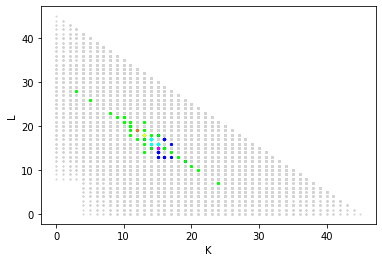

In [83]:
import matplotlib.pyplot as plt


ax1 = df.plot(kind='scatter', x='K', y='L', color='lightgray', s=1)    
ax2 = df.query("selected==1").plot(kind='scatter', x='K', y='L', color='blue', ax=ax1, s=5)    
ax3 = df.query("selected==2").plot(kind='scatter', x='K', y='L', color='lime', ax=ax1, s=5) 
ax4 = df.query("selected==3").plot(kind='scatter', x='K', y='L', color='cyan', ax=ax1, s=5) 
ax5 = df.query("selected==4").plot(kind='scatter', x='K', y='L', color='magenta', ax=ax1, s=5)    
ax6 = df.query("selected==5").plot(kind='scatter', x='K', y='L', color='yellow', ax=ax1, s=5) 
ax6 = df.query("selected==6").plot(kind='scatter', x='K', y='L', color='tomato', ax=ax1, s=5) 

plt.savefig("KL.svg")




In [65]:
smiles = df.query("seq=='(KKK)8(KKKK)4(KKKK)2KKKK'").SMILES.to_list()[0]
mol = MolFromSmiles(smiles)
mw = Descriptors.ExactMolWt(mol)
mw

TypeError: No registered converter was able to produce a C++ rvalue of type std::__cxx11::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type tuple

In [ ]:
smiles = df.query("seq=='(KKK)8(KKKK)4(KKKK)2K'").SMILES.to_list()[0]
mol = MolFromSmiles(smiles)
mw = Descriptors.ExactMolWt(mol)
mw


In [ ]:
smiles

In [ ]:
df.query("seq=='(KKK)8(KKKK)4(KKKK)2K'").seq2.to_list()[0]